In [23]:
#imports
import requests
import json
import pandas as pd
import numpy as np
import warnings
import random
import matplotlib.pyplot as plt
from datetime import datetime
import time as clock

start_time = clock.time()
# Sensors_Data = pd.read_json('data/W512_readings.json')
# Aircon_Data = pd.read_json('data/W512_aircon_status.json')
# Weather_Data = pd.read_json('data/Weather_data.json')

Sensors_Data = pd.read_json('../test/SPGG_readings1.json')
Aircon_Data = pd.read_json('../test/SPGG_aircon_status1.json')
Weather_Data = pd.read_json('../test/Weather_data1.json')
# Aircon_Data = Aircon_Data.iloc[3194:] #testing out new dataset (data is cleaned before pulling)
# Normalize the data
Aircon_rows = []

for _, row in Aircon_Data.iterrows():
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    fc_readings = row['FC_FullStatus_Readings']
    if fc_readings and isinstance(fc_readings, dict):
        for unit, data in fc_readings.items():
            if any(data.get("Set_Point", None) == 404.0 for data in fc_readings.values()):
                continue
            flattened_row[f"{unit}_Status"] = data.get("Status", None)
            flattened_row[f"{unit}_Fan_Status"] = data.get("Fan_Status", None)
            flattened_row[f"{unit}_Set_Point"] = data.get("Set_Point", None)
            flattened_row[f"{unit}_Operation_Mode"] = data.get("Operation_Mode", None)
    
    Aircon_rows.append(flattened_row)

Sensors_rows = []
for _, row in Sensors_Data.iterrows():
    invalid_input = False
    
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    
    lorawan_readings = row['Lorawan_Readings']
    
    if isinstance(lorawan_readings, dict):
        for unit, data in lorawan_readings.items():
            if isinstance(data, dict):  # Ensure that each item in Lorawan_Readings is a dictionary
                for key, value in data.items():
                    flattened_row[f"{unit}_{key}"] = value
            
    energy_readings = row['Energy_Readings']
    total_power = 0
    total_energy = 0
    invalid_input_power = False
    invalid_input_energy = False
    
    if energy_readings and isinstance(energy_readings, dict):
        for unit, data in energy_readings.items():
            power = data.get('Power', None)
            energy = data.get('Energy', None)
            if power is None:
                invalid_input_power = True
            if energy is None:
                invalid_input_energy = True
            total_power += power
            total_energy += energy
        
    if invalid_input_power:
        total_power = None
    if invalid_input_energy:
        total_energy = None
        
    flattened_row["Total_Energy"] = total_energy
    flattened_row["Total_Power"] = total_power
    
    Sensors_rows.append(flattened_row)


# Normalize the data
Weather_rows = []

for _, row in Weather_Data.iterrows():
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    flattened_row['weather_status']= row['result']['weather_status']
    flattened_row['weather_temp']= row['result']['weather_temp']
    flattened_row['weather_humidity']= row['result']['weather_humidity']
    
    Weather_rows.append(flattened_row)



Aircon_Normalize_Data = pd.DataFrame(Aircon_rows)
Sensors_Normalize_Data = pd.DataFrame(Sensors_rows)
Weather_Normalize_Data = pd.DataFrame(Weather_rows)
# For Aircon_Normalize_Data
Aircon_Normalize_Data['datetime_str'] = Aircon_Normalize_Data['date'].astype(str) + ' ' + Aircon_Normalize_Data['time']
Aircon_Normalize_Data['datetime'] = Aircon_Normalize_Data['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Aircon_Normalize_Data['timestamp'] = Aircon_Normalize_Data['datetime'].apply(lambda x: int(x.timestamp()))

# For Sensors_Normalize_Data
Sensors_Normalize_Data['datetime_str'] = Sensors_Normalize_Data['date'].astype(str) + ' ' + Sensors_Normalize_Data['time']
Sensors_Normalize_Data['datetime'] = Sensors_Normalize_Data['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Sensors_Normalize_Data['timestamp'] = Sensors_Normalize_Data['datetime'].apply(lambda x: int(x.timestamp()))

# For Weather_Normalize_Data
Weather_Normalize_Data['datetime_str'] = Weather_Normalize_Data['date'].astype(str) + ' ' + Weather_Normalize_Data['time']
Weather_Normalize_Data['datetime'] = Weather_Normalize_Data['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Weather_Normalize_Data['timestamp'] = Weather_Normalize_Data['datetime'].apply(lambda x: int(x.timestamp()))

merged_data = pd.merge_asof(
    Aircon_Normalize_Data,  # Left DataFrame
    Sensors_Normalize_Data,      # Right DataFrame
    on='timestamp',   # Key column
    direction='nearest'    # Match the nearest time
)
merged_data = pd.merge_asof(
    merged_data,  # Left DataFrame
    Weather_Normalize_Data,      # Right DataFrame
    on='timestamp',   # Key column
    direction='nearest'    # Match the nearest time
)
merged_data.columns
temperature_col = [
    col for col in merged_data.columns 
    if "temperature" in col.lower() and "24e124136d336145" not in col.lower()
]

outdoor_col = [
    col for col in merged_data.columns 
    if "24e124136d336145" in col.lower()
]

door_col = [
    col for col in merged_data.columns
    if "24e124141e173857" in col.lower()
]

humidity_col = [
    col for col in merged_data.columns 
    if "humidity" in col.lower()
]

occupancy_col_total_in = [
    col for col in merged_data.columns
    if "line_1_total_in" in col.lower()
]

occupancy_col_total_out = [
    col for col in merged_data.columns
    if "line_1_total_out" in col.lower()
]

def get_unit_columns(unit_number, columns):
    return [col for col in columns if f"FC_Unit_{unit_number}" in col]

aircon_units = len([
    col for col in merged_data.columns
    if "FC_Unit_" in col and "_Status" in col and "Fan" not in col
])

aircon_units_cols = {}

for unit in range(1, aircon_units + 1):
    aircon_units_cols[f'Unit_{unit}'] = get_unit_columns(unit, merged_data.columns)
    

# Creating the wanted fields
final_data = pd.DataFrame()
final_data["timestamp"] = merged_data["timestamp"]

final_data["temperature"] = merged_data[temperature_col].apply(lambda x: round(x.mean(), 3), axis=1)
final_data["humidity"] = merged_data[humidity_col].apply(lambda x: round(x.mean(),3), axis=1)

final_data['power_consumption'] = merged_data['Total_Power']
final_data['energy_consumption'] = merged_data['Total_Energy']

final_data["outdoor_temperature"] = merged_data[outdoor_col]['24E124136D336145_temperature'].ffill()
final_data["outdoor_humidity"] = merged_data[outdoor_col]['24E124136D336145_humidity'].ffill()

final_data["weather_status"] = merged_data["weather_status"]
final_data["weather_temp"] = merged_data['weather_temp']
final_data["weather_humid"] = merged_data['weather_humidity']

#0 is door closed, 1 is door opened
final_data["door_status"] = merged_data[door_col]["24E124141E173857_magnet_status"].ffill()

merged_data[occupancy_col_total_in] = merged_data[occupancy_col_total_in].fillna(method='bfill')
merged_data[occupancy_col_total_out] = merged_data[occupancy_col_total_out].fillna(method='bfill')

final_data['occupancy'] = (
    merged_data[occupancy_col_total_in].sum(axis=1) - merged_data[occupancy_col_total_out].sum(axis=1)
).clip(lower=0)

for unit, columns in aircon_units_cols.items():
    for column in columns:
        if 'set_point' in column:
            final_data[column] = merged_data[column].replace(0, pd.NA).ffill()
        else:
            final_data[column] = merged_data[column].replace("ERROR", pd.NA).ffill()

final_data.dropna(inplace=True)
# final_data.reset_index(drop=True, inplace=True)#######################################

print("final_data_created")

# # Sorting the data by energy_consumption in ascending order
# final_data = final_data.sort_values(by="timestamp", ascending=True)
final_data.to_csv("test.csv", index=False)

def getFCData(data, row_index):
    settings = []
    for i in range(1, aircon_units + 1):
        settings.append(data[f"FC_Unit_{i}_Status"].iloc[row_index])
        settings.append(data[f"FC_Unit_{i}_Fan_Status"].iloc[row_index])
        settings.append(data[f"FC_Unit_{i}_Set_Point"].iloc[row_index])
        settings.append(data[f"FC_Unit_{i}_Operation_Mode"].iloc[row_index])
        
    return settings

def is_same_settings(data, curr_row_index, next_row_index):   
    return True if (getFCData(data, curr_row_index) == getFCData(data, next_row_index)) else False


def is_all_off(data, curr_row_index, check_for_off):
    for i in range(1, aircon_units + 1):
        if data[f"FC_Unit_{i}_Status"].iloc[curr_row_index] == "ON":
            return not check_for_off
        
    return check_for_off

def is_within_time_range(data, curr_row_index, next_row_index):
    if data["timestamp"].iloc[next_row_index] - data["timestamp"].iloc[curr_row_index] < 1800:
        return True
    else:
        return False


aircon_status_result = pd.DataFrame()
total_final_rows = final_data.shape[0]
Aircon_Normalize_Data = Aircon_Normalize_Data.drop(['date', 'time', 'datetime_str', 'datetime', 'timestamp'], axis=1)

for i in range(total_final_rows - 1):
    if is_all_off(final_data, i ,True):
        continue
    
    curr_timestamp = final_data["timestamp"].iloc[i]
    
    curr_energy = final_data["energy_consumption"].iloc[i]
    next_energy = final_data["energy_consumption"].iloc[i + 1]
    
    curr_temperature = final_data["temperature"].iloc[i]
    next_temperature = final_data["temperature"].iloc[i + 1]

    curr_humidity = final_data["humidity"].iloc[i]

    # curr_weather_status = final_data["weather_status"].iloc[i]
    # curr_weather_temp = final_data["weather_temp"].iloc[i]
    # curr_weather_humid = final_data["weather_humid"].iloc[i]

    curr_outdoor_temp = final_data["outdoor_temperature"].iloc[i]
    curr_outdoor_humid = final_data["outdoor_humidity"].iloc[i]

    if is_same_settings(final_data,i, i+ 1) and is_within_time_range(final_data,i, i+ 1):
        diff = next_energy - curr_energy
        if diff < 0:
            diff = 0

    temp_df = pd.DataFrame({
        'timestamp': [curr_timestamp],
        'energy_consumption': [diff],
        'temperature': [curr_temperature],
        'humidity': [curr_humidity],
        'outdoor_temp':[curr_outdoor_temp],
        'outdoor_humid':[curr_outdoor_humid]
        
    })
    for col in Aircon_Normalize_Data.columns:
        temp_df[col] = final_data[col].iloc[i]

    aircon_status_result = pd.concat([aircon_status_result, temp_df], ignore_index=False)


# Optionally, you can save the updated dataframe
aircon_status_result.to_csv("updated_test.csv", index=False)




C:\Users\yy\AppData\Local\Temp\ipykernel_29148\3603516471.py:209: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[occupancy_col_total_in] = merged_data[occupancy_col_total_in].fillna(method='bfill')
C:\Users\yy\AppData\Local\Temp\ipykernel_29148\3603516471.py:210: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[occupancy_col_total_out] = merged_data[occupancy_col_total_out].fillna(method='bfill')


final_data_created


C:\Users\yy\AppData\Local\Temp\ipykernel_29148\1522483084.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


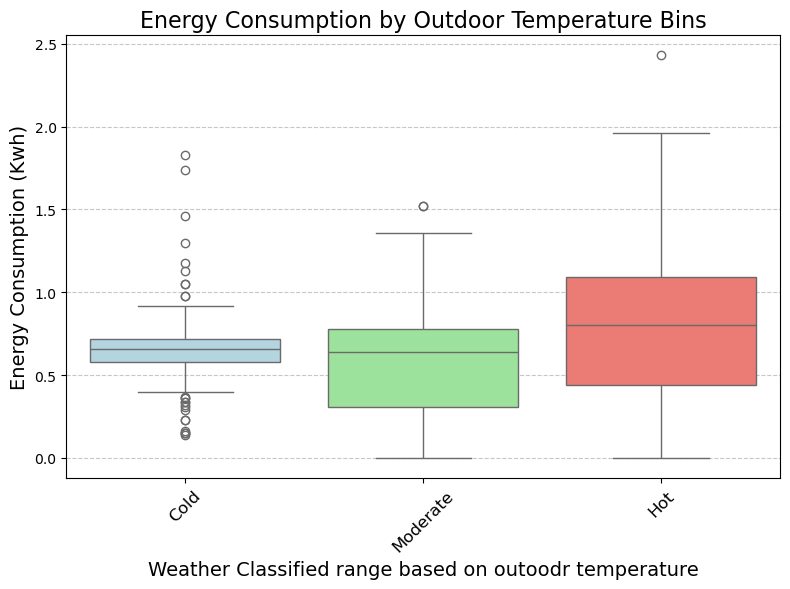

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define dynamic thresholds
hot_threshold = np.percentile(aircon_status_result["outdoor_temp"], 70)  # Top 30%
cold_threshold = np.percentile(aircon_status_result["outdoor_temp"], 30)  # Bottom 30%

def categorize_temperature(temp):
    if temp >= hot_threshold:
        return "Hot"
    elif temp <= cold_threshold:
        return "Cold"
    else:
        return "Moderate"

# Apply the categorization function
aircon_status_result["temperature_category"] = aircon_status_result["outdoor_temp"].apply(categorize_temperature)

# Create the boxplot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=aircon_status_result,
    x="temperature_category",
    y="energy_consumption",
    palette = {
        "Cold": "lightblue",  # Valid Seaborn color
        "Moderate": "lightgreen",  # Valid Seaborn color
        "Hot": "#FF6961"  # Hex code for a "light red" shade
    },
    order=["Cold", "Moderate", "Hot"]  # Ensure consistent order
)

# Add labels and title
plt.title("Energy Consumption by Outdoor Temperature Bins", fontsize=16)
plt.xlabel("Weather Classified range based on outoodr temperature", fontsize=14)
plt.ylabel("Energy Consumption (Kwh)", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


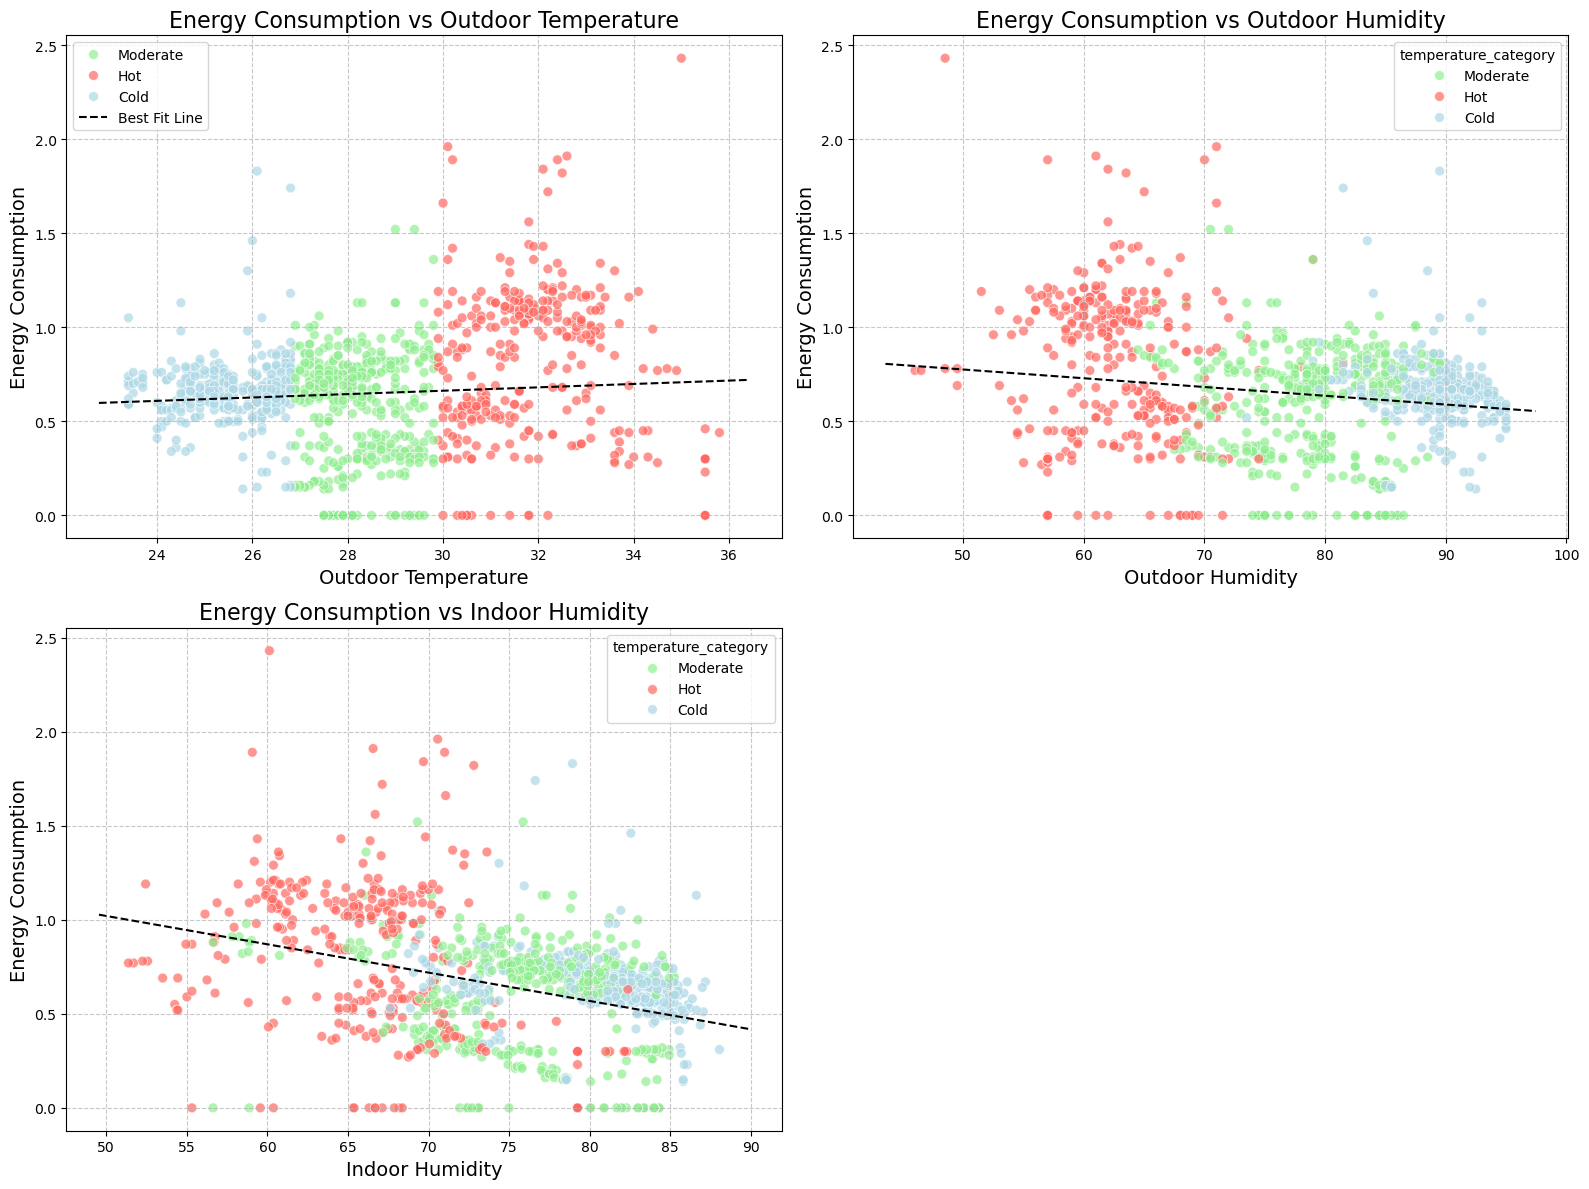

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress

# Create a figure and axis
plt.figure(figsize=(16, 12))

# Define dynamic thresholds for categorizing temperature
hot_threshold = np.percentile(aircon_status_result["outdoor_temp"], 70)  # Top 30%
cold_threshold = np.percentile(aircon_status_result["outdoor_temp"], 30)  # Bottom 30%

def categorize_temperature(temp):
    if temp >= hot_threshold:
        return "Hot"
    elif temp <= cold_threshold:
        return "Cold"
    else:
        return "Moderate"

# Apply the categorization function
aircon_status_result["temperature_category"] = aircon_status_result["outdoor_temp"].apply(categorize_temperature)

# Define color palette for temperature categories
color_palette = {
    "Cold": "lightblue", 
    "Moderate": "lightgreen",  
    "Hot": "#FF6961"  
}

# Function to plot the best fit line
def plot_best_fit_line(x_data, y_data):
    slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)
    x_vals = np.array(plt.gca().get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color='black', label='Best Fit Line')
    return slope, intercept

# First subplot: Outdoor temperature vs energy consumption
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.scatterplot(
    data=aircon_status_result,
    x="outdoor_temp",
    y="energy_consumption",
    hue="temperature_category",
    palette=color_palette,
    s=50,  
    alpha=0.7  
)

# Plot the best fit line for outdoor_temp vs energy_consumption
plot_best_fit_line(aircon_status_result["outdoor_temp"], aircon_status_result["energy_consumption"])

# Add labels and title for the first subplot
plt.title("Energy Consumption vs Outdoor Temperature", fontsize=16)
plt.xlabel("Outdoor Temperature", fontsize=14)
plt.ylabel("Energy Consumption", fontsize=14)
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Second subplot: Outdoor humidity vs energy consumption
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.scatterplot(
    data=aircon_status_result,
    x="outdoor_humid",
    y="energy_consumption",
    hue="temperature_category",
    palette=color_palette,
    s=50,  
    alpha=0.7  
)

# Plot the best fit line for outdoor_humid vs energy_consumption
plot_best_fit_line(aircon_status_result["outdoor_humid"], aircon_status_result["energy_consumption"])

# Add labels and title for the second subplot
plt.title("Energy Consumption vs Outdoor Humidity", fontsize=16)
plt.xlabel("Outdoor Humidity", fontsize=14)
plt.ylabel("Energy Consumption", fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Third subplot: Indoor humidity vs energy consumption
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, 3rd subplot
sns.scatterplot(
    data=aircon_status_result,
    x="humidity",
    y="energy_consumption",
    hue="temperature_category",
    palette=color_palette,
    s=50,  
    alpha=0.7  
)

# Plot the best fit line for indoor humidity vs energy_consumption
plot_best_fit_line(aircon_status_result["humidity"], aircon_status_result["energy_consumption"])

# Add labels and title for the third subplot
plt.title("Energy Consumption vs Indoor Humidity", fontsize=16)
plt.xlabel("Indoor Humidity", fontsize=14)
plt.ylabel("Energy Consumption", fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Tight layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

aircon_resul